#Downloading the dataset

In [1]:


from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
100% 812M/812M [00:07<00:00, 129MB/s]
100% 812M/812M [00:07<00:00, 118MB/s]


#Copying images to training,validation and test directories

In [2]:


import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train17", start_index=0, end_index=10000)
make_subset("validation17", start_index=10000, end_index=10500)
make_subset("test17", start_index=10500, end_index=11000)

#Building the Model

In [3]:


from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

#Configuring the model for training

In [5]:


model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#Data Processing

In [6]:


from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train17",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation17",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test17",
    image_size=(180, 180),
    batch_size=32)

Found 20000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [7]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [8]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [9]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [10]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


#Displaying the shapes of the data and labels yielded by the Dataset

In [11]:


for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


#Fitting the model using a Dataset

In [12]:


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 52s 59ms/step - loss: 0.6298 - accuracy: 0.6363 - val_loss: 0.4884 - val_accuracy: 0.7700
Epoch 2/30
625/625 [==============================] - 32s 50ms/step - loss: 0.4834 - accuracy: 0.7714 - val_loss: 0.4402 - val_accuracy: 0.8100
Epoch 3/30
625/625 [==============================] - 33s 53ms/step - loss: 0.3857 - accuracy: 0.8291 - val_loss: 0.3750 - val_accuracy: 0.8360
Epoch 4/30
625/625 [==============================] - 31s 50ms/step - loss: 0.3059 - accuracy: 0.8679 - val_loss: 0.6442 - val_accuracy: 0.7490
Epoch 5/30
625/625 [==============================] - 32s 51ms/step - loss: 0.2412 - accuracy: 0.8978 - val_loss: 0.2508 - val_accuracy: 0.8940
Epoch 6/30
625/625 [==============================] - 31s 49ms/step - loss: 0.1884 - accuracy: 0.9230 - val_loss: 0.4387 - val_accuracy: 0.8580
Epoch 7/30
625/625 [==============================] - 32s 51ms/step - loss: 0.1499 - accuracy: 0.9430 - val_loss: 0.3306 - val_accuracy:

#Displaying curves of loss and accuracy during training

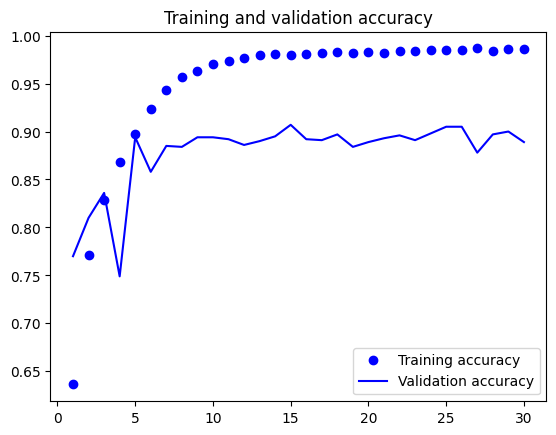

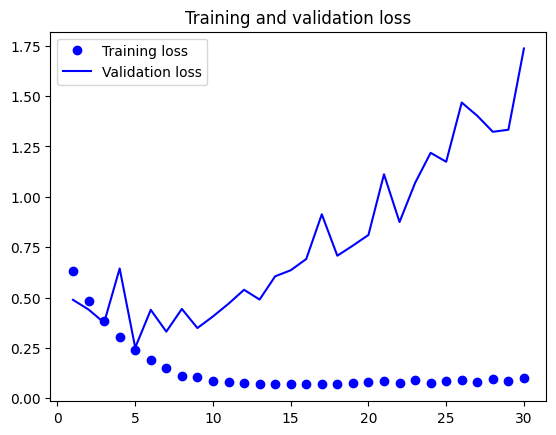

In [13]:


import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.2769 - accuracy: 0.8770
Test accuracy: 0.877


#Using data Augmentation

In [15]:


data_augmentation = keras.Sequential(
    [
       layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.01),
    ]
)

Displaying some randomly augmented training images

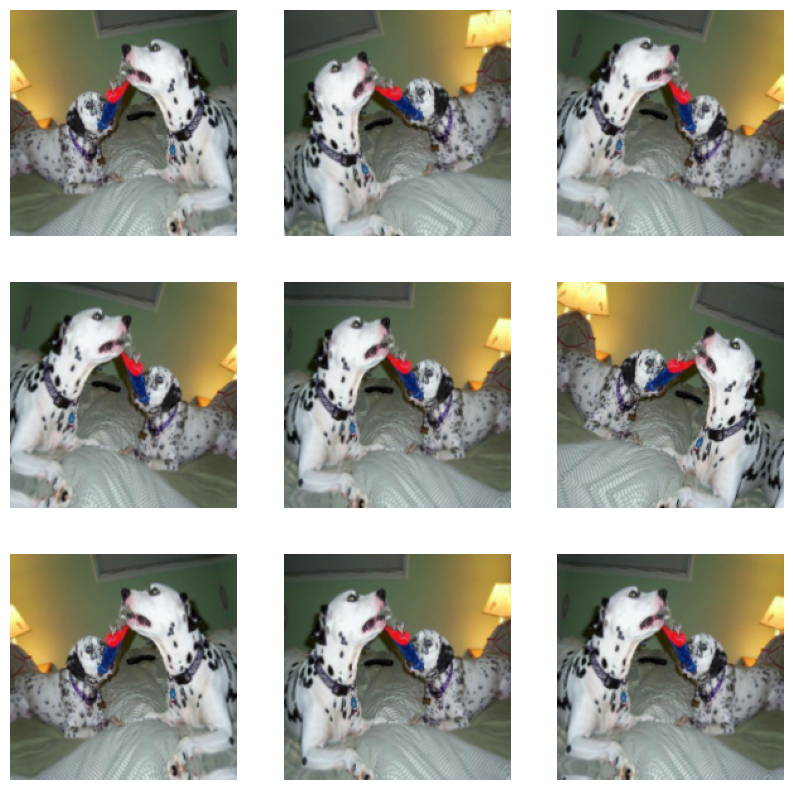

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#Defining a new convnet that includes image augmentation and dropout

In [17]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=1)(x)
x = layers.Conv2D(filters=64, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=12)(x)
x = layers.Conv2D(filters=128, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=256, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=1)(x)
x = layers.Conv2D(filters=256, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#Training the regularized convnet

In [18]:


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=7,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/7
625/625 [==============================] - 43s 62ms/step - loss: 0.5959 - accuracy: 0.6616 - val_loss: 0.5120 - val_accuracy: 0.7330
Epoch 2/7
625/625 [==============================] - 39s 62ms/step - loss: 0.4575 - accuracy: 0.7843 - val_loss: 0.3816 - val_accuracy: 0.8190
Epoch 3/7
625/625 [==============================] - 39s 61ms/step - loss: 0.4044 - accuracy: 0.8152 - val_loss: 0.4448 - val_accuracy: 0.7960
Epoch 4/7
625/625 [==============================] - 39s 61ms/step - loss: 0.3637 - accuracy: 0.8367 - val_loss: 0.3318 - val_accuracy: 0.8440
Epoch 5/7
625/625 [==============================] - 38s 61ms/step - loss: 0.3387 - accuracy: 0.8530 - val_loss: 0.2843 - val_accuracy: 0.8690
Epoch 6/7
625/625 [==============================] - 39s 62ms/step - loss: 0.3129 - accuracy: 0.8630 - val_loss: 0.2834 - val_accuracy: 0.8800
Epoch 7/7
625/625 [==============================] - 39s 62ms/step - loss: 0.2952 - accuracy: 0.8700 - val_loss: 0.3189 - val_accuracy: 0.8580

#Evaluating the model on the test set

In [19]:


test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 32ms/step - loss: 0.3158 - accuracy: 0.8630
Test accuracy: 0.863


Pretrained model

In [20]:

from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Extracting the features and corresponding labels**

In [22]:


import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 22ms/step


In [23]:

train_features.shape

(20000, 5, 5, 512)

Defining and training the densely connected classifier

In [24]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)



Epoch 1/20
625/625 [==============================] - 3s 4ms/step - loss: 6.9725 - accuracy: 0.9603 - val_loss: 4.0616 - val_accuracy: 0.9720
Epoch 2/20
625/625 [==============================] - 3s 4ms/step - loss: 2.4586 - accuracy: 0.9793 - val_loss: 4.2737 - val_accuracy: 0.9610
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 1.2447 - accuracy: 0.9833 - val_loss: 3.3456 - val_accuracy: 0.9640
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.7791 - accuracy: 0.9857 - val_loss: 2.6653 - val_accuracy: 0.9740
Epoch 5/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6263 - accuracy: 0.9882 - val_loss: 2.4966 - val_accuracy: 0.9730
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4799 - accuracy: 0.9898 - val_loss: 3.0125 - val_accuracy: 0.9720
Epoch 7/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4490 - accuracy: 0.9920 - val_loss: 3.6524 - val_accuracy: 0.9730
Epoch 

Plotting the result

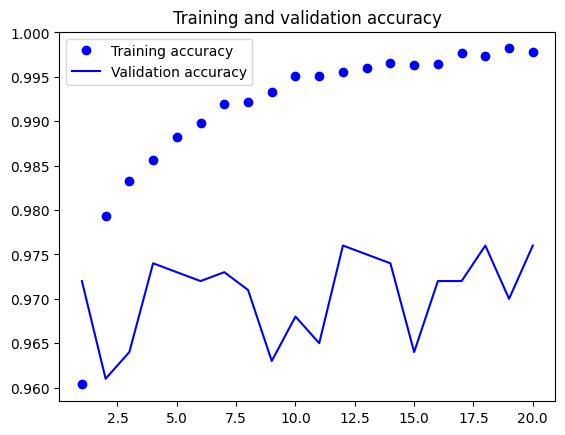

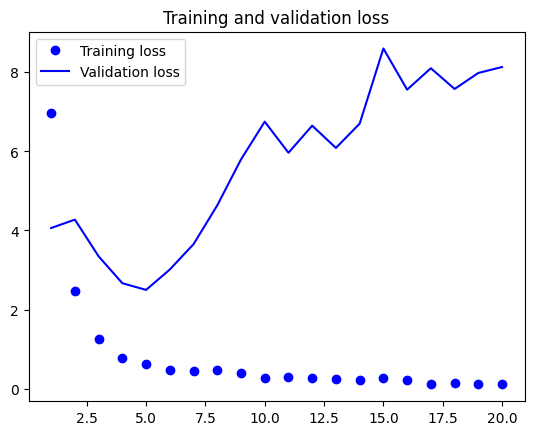

In [25]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Instantiating and freezing the convolutional base

In [26]:


conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [27]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26


In [28]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.9)(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)
     

Epoch 1/20
625/625 [==============================] - 68s 105ms/step - loss: 30.2621 - accuracy: 0.7964 - val_loss: 4.4968 - val_accuracy: 0.9730
Epoch 2/20
625/625 [==============================] - 63s 100ms/step - loss: 11.1439 - accuracy: 0.8364 - val_loss: 0.8396 - val_accuracy: 0.9740
Epoch 3/20
625/625 [==============================] - 63s 101ms/step - loss: 2.8240 - accuracy: 0.8248 - val_loss: 0.5171 - val_accuracy: 0.9760
Epoch 4/20
625/625 [==============================] - 62s 99ms/step - loss: 2.8183 - accuracy: 0.8310 - val_loss: 0.6617 - val_accuracy: 0.9750
Epoch 5/20
625/625 [==============================] - 63s 100ms/step - loss: 2.8447 - accuracy: 0.8408 - val_loss: 0.6765 - val_accuracy: 0.9690
Epoch 6/20
625/625 [==============================] - 63s 100ms/step - loss: 2.9027 - accuracy: 0.8404 - val_loss: 0.7558 - val_accuracy: 0.9720
Epoch 7/20
625/625 [==============================] - 63s 100ms/step - loss: 2.9767 - accuracy: 0.8459 - val_loss: 0.7192 - val_a

Evaluating the model on the test set

In [31]:

test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 89ms/step - loss: 0.4775 - accuracy: 0.9650
Test accuracy: 0.965


Fine-tuning a pretrained model

In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers until the fourth from the last

In [33]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [34]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/15
625/625 [==============================] - 76s 118ms/step - loss: 0.7552 - accuracy: 0.8446 - val_loss: 0.2132 - val_accuracy: 0.9620
Epoch 2/15
625/625 [==============================] - 73s 117ms/step - loss: 0.2794 - accuracy: 0.8963 - val_loss: 0.2079 - val_accuracy: 0.9620
Epoch 3/15
625/625 [==============================] - 73s 116ms/step - loss: 0.2489 - accuracy: 0.9107 - val_loss: 0.1859 - val_accuracy: 0.9640
Epoch 4/15
625/625 [==============================] - 73s 116ms/step - loss: 0.2183 - accuracy: 0.9196 - val_loss: 0.2108 - val_accuracy: 0.9630
Epoch 5/15
625/625 [==============================] - 73s 116ms/step - loss: 0.2095 - accuracy: 0.9250 - val_loss: 0.1871 - val_accuracy: 0.9650
Epoch 6/15
625/625 [==============================] - 73s 116ms/step - loss: 0.2053 - accuracy: 0.9283 - val_loss: 0.1707 - val_accuracy: 0.9620
Epoch 7/15
625/625 [==============================] - 73s 116ms/step - loss: 0.2014 - accuracy: 0.9346 - val_loss: 0.1998 - val_ac

In [35]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")
     

32/32 [==============================] - 3s 90ms/step - loss: 0.1427 - accuracy: 0.9610
Test accuracy: 0.961
